In [32]:
import os
from os.path import join
import numpy as np
import pandas as pd
from glob import glob
from joblib import Parallel, delayed
import xarray as xr
from tqdm.notebook import tqdm, trange
import matplotlib.pyplot as plt

## Basic statistics

In [2]:
files = glob("../another_files/*/*/*/*.csv")
print("Total files:", len(files))
files[0]

Total files: 3062


'../another_files/Punjab/Khanna/Kalal Majra, Khanna - PPCB/Raw_data_15Min_2020_site_1450_Kalal_Majra_Khanna_PPCB_15Min.csv'

In [3]:
stations = list(set([file.split("/")[-2] for file in files]))
print("Total stations:", len(stations))
stations[0]

Total stations: 537


'RIMT University, Mandi Gobindgarh - PPCB'

In [4]:
cities = list(set([file.split("/")[-3] for file in files]))
print("Total cities:", len(cities))
cities[0]

Total cities: 279


'Mandideep'

In [5]:
states = list(set([file.split("/")[-4] for file in files]))
print("Total states:", len(states))
states[0]

Total states: 31


'Gujarat'

## Load location info

In [6]:
station_data = pd.read_pickle("station_data.pkl")

In [7]:
set(station_data.keys()) - set(stations)

{'Charitra Van, Buxar - BSPCB (Formerly known as Central Jail)',
 'Rajiv Nagar, Vijayawada - APPCB',
 'Vasundhara Nagar_UIT, Bhiwadi - RSPCB'}

These 3 stations are not available in data because data for them is not available in the CPCB portal.

## Process all files

In [8]:
def process_file(file):
    try:
        df = pd.read_csv(file)
        state_name = file.split("/")[-4]
        city_name = file.split("/")[-3]
        station_name = file.split("/")[-2]
        if len(df) == 0:
            return None
        df["Timestamp"] = pd.to_datetime(df["Timestamp"], format="%Y-%m-%d %H:%M:%S")
        lon = station_data[station_name]["longitude"]
        lat = station_data[station_name]["latitude"]
        df["station"] = station_name
        df.set_index(["Timestamp", "station"], inplace=True)
        ds = df.to_xarray()
        ds.coords["longitude"] = ("station", [lon])
        ds.coords["latitude"] = ("station", [lat])
        
        # preprocess variable names
        for var_name in ds.data_vars:
            # print(var_name)
            name, unit = var_name.split("(")
            unit = unit.replace(")", "")
            # add metadata
            ds[var_name].attrs["unit"] = unit.strip()
            # change variable name
            # print(name, unit)
            name = name.strip()
            ds = ds.rename({var_name: name})
        
        base_path = "/home/patel_zeel/cpcb_helper/nc_files"
        mid_path = f"{state_name}/{city_name}/{station_name}"
        save_dir = join(base_path, mid_path)
        os.makedirs(save_dir, exist_ok=True)
        save_path = join(save_dir, file.split('/')[-1].replace('.csv', '.nc'))
        ds.to_netcdf(save_path)
        return save_path

    except Exception as e:
        print(e)
        raise e

example_path = process_file(files[0])
print(example_path)
with xr.open_dataset(example_path) as ds:
    pass
ds

/home/patel_zeel/cpcb_helper/nc_files/Punjab/Khanna/Kalal Majra, Khanna - PPCB/Raw_data_15Min_2020_site_1450_Kalal_Majra_Khanna_PPCB_15Min.nc


<xarray.Dataset>
Dimensions:      (Timestamp: 35136, station: 1)
Coordinates:
  * Timestamp    (Timestamp) datetime64[ns] 2020-01-01 ... 2020-12-31T23:45:00
  * station      (station) object 'Kalal Majra, Khanna - PPCB'
    longitude    (station) float64 ...
    latitude     (station) float64 ...
Data variables: (12/24)
    PM2.5        (Timestamp, station) float64 ...
    PM10         (Timestamp, station) float64 ...
    NO           (Timestamp, station) float64 ...
    NO2          (Timestamp, station) float64 ...
    NOx          (Timestamp, station) float64 ...
    NH3          (Timestamp, station) float64 ...
    ...           ...
    WD           (Timestamp, station) float64 ...
    RF           (Timestamp, station) float64 ...
    TOT-RF       (Timestamp, station) float64 ...
    SR           (Timestamp, station) float64 ...
    BP           (Timestamp, station) float64 ...
    VWS          (Timestamp, station) float64 ...

In [9]:
nc_data_list = Parallel(n_jobs=48)(delayed(process_file)(file) for file in tqdm(files))

  0%|          | 0/3062 [00:00<?, ?it/s]

Filter None files because of 0 entries in the CSV.

In [10]:
len(nc_data_list)

3062

In [11]:
clean_nc_data_list = [nc_data for nc_data in nc_data_list if nc_data is not None]
len(clean_nc_data_list)

2936

## Export station data as csv

In [12]:
df = pd.DataFrame(station_data).T
df.index.name = "station"
df.reset_index(inplace=True)
df.head(2)

,station,address,latitude,longitude
0,"SIDCO Kurichi, Coimbatore - TNPCB","SIDCO Kurichi, Coimbatore, Tamil Nadu.",10.942451,76.978996
1,"Muradpur, Patna - BSPCB","S K Memorial Hall Premises, Near Gandhi Maidan...",25.619651,85.147382


In [13]:
df.to_csv("station_data.csv", index=None)

## Some postprocessing due to duplication of data

Som states have same district names and thus data from stations from both districts are present at both places. We need to delete irrelevant data from corresponding states.

In [14]:
!rm -r "../another_files/Bihar/Aurangabad/More Chowk Waluj, Aurangabad - MPCB/"
!rm -r "../nc_files/Bihar/Aurangabad/More Chowk Waluj, Aurangabad - MPCB/"

rm: cannot remove '../another_files/Bihar/Aurangabad/More Chowk Waluj, Aurangabad - MPCB/': No such file or directory
rm: cannot remove '../nc_files/Bihar/Aurangabad/More Chowk Waluj, Aurangabad - MPCB/': No such file or directory


In [15]:
!rm -r "../another_files/Bihar/Aurangabad/MIDC Chilkalthana, Aurangabad - MPCB/"
!rm -r "../nc_files/Bihar/Aurangabad/MIDC Chilkalthana, Aurangabad - MPCB/"

rm: cannot remove '../another_files/Bihar/Aurangabad/MIDC Chilkalthana, Aurangabad - MPCB/': No such file or directory
rm: cannot remove '../nc_files/Bihar/Aurangabad/MIDC Chilkalthana, Aurangabad - MPCB/': No such file or directory


In [16]:
!rm -r "../another_files/Maharashtra/Aurangabad/Gurdeo Nagar, Aurangabad - BSPCB/"
!rm -r "../nc_files/Maharashtra/Aurangabad/Gurdeo Nagar, Aurangabad - BSPCB/"

rm: cannot remove '../another_files/Maharashtra/Aurangabad/Gurdeo Nagar, Aurangabad - BSPCB/': No such file or directory
rm: cannot remove '../nc_files/Maharashtra/Aurangabad/Gurdeo Nagar, Aurangabad - BSPCB/': No such file or directory


In [17]:
!rm -r "../another_files/Bihar/Aurangabad/Rachnakar Colony, Aurangabad - MPCB/"
!rm -r "../nc_files/Bihar/Aurangabad/Rachnakar Colony, Aurangabad - MPCB/"

rm: cannot remove '../another_files/Bihar/Aurangabad/Rachnakar Colony, Aurangabad - MPCB/': No such file or directory
rm: cannot remove '../nc_files/Bihar/Aurangabad/Rachnakar Colony, Aurangabad - MPCB/': No such file or directory


## Trying to combine all files into one

In [3]:
nc_list = glob("../nc_files/*/*/*/*.nc")
len(nc_list)

2936

In [3]:
nc_stations_list = list(set(["/".join(f.split("/")[:-1]) for f in nc_list]))
len(nc_stations_list)

537

In [31]:
def merge_years(path):
    files = glob(join(path, "*.nc"))
    ds = xr.merge([xr.open_dataset(file).load() for file in files])
    path = path.replace("../nc_files", "/tmp/aq_tmp")
    os.makedirs(path, exist_ok=True)
    ds.to_netcdf(join(path, "merged_years.nc"))
    
_ = Parallel(n_jobs=48)(delayed(merge_years)(path) for path in tqdm(nc_stations_list))

  0%|          | 0/537 [00:00<?, ?it/s]

In [4]:
merged_nc_list = glob("/tmp/aq_tmp/*/*/*/*.nc")
cities_path_list = list(set(["/".join(f.split("/")[:-2]) for f in merged_nc_list]))
print(len(cities_path_list))
cities_path_list[0]

280


'/tmp/aq_tmp/Kerala/Kollam'

In [34]:
for path in tqdm(cities_path_list):
    files = glob(join(path, "*/merged_years.nc"))
    ds = xr.merge([xr.open_dataset(file).load() for file in files])
    ds.to_netcdf(join(path, "merged_stations.nc"))

  0%|          | 0/280 [00:00<?, ?it/s]

In [5]:
states_path = list(set(["/".join(f.split("/")[:-1]) for f in cities_path_list]))
print(len(states_path))
states_path[0]

31


'/tmp/aq_tmp/Delhi'

In [6]:
pbar = tqdm(states_path)
for path in pbar:
    files = glob(join(path, "*/merged_stations.nc"))
    pbar.set_description(f"{path}: {len(files)}")
    ds_list = [xr.open_dataset(file).load() for file in tqdm(files)]
    pbar.set_description(f"{path}: {len(files)} merging")
    ds = xr.merge(ds_list)
    pbar.set_description(f"{path}: {len(files)} saving")
    ds.to_netcdf(join(path, "merged_cities.nc"))

  0%|          | 0/31 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/34 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/27 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

## Final merge

In [12]:
state_files = glob("/tmp/aq_tmp/*/merged_cities.nc")
ds_list = [xr.open_dataset(file).load() for file in tqdm(state_files)]
ds = xr.concat(ds_list, dim="station")
ds.to_netcdf("/tmp/aq_tmp/merged_states.nc")

  0%|          | 0/31 [00:00<?, ?it/s]

In [19]:
len(ds.Timestamp) - 4*24*(365*6 + 366)

0

In [20]:
ds

<xarray.Dataset>
Dimensions:      (Timestamp: 245376, station: 537)
Coordinates:
  * Timestamp    (Timestamp) datetime64[ns] 2017-01-01 ... 2023-12-31T23:45:00
  * station      (station) object '32Bungalows, Bhilai - CECB' ... 'Ward-32 B...
    longitude    (station) float64 81.31 81.58 81.63 81.34 ... 87.29 88.34 88.42
    latitude     (station) float64 21.19 21.26 21.22 21.19 ... 23.54 22.54 26.69
Data variables: (12/24)
    PM2.5        (Timestamp, station) float64 nan nan nan nan ... nan nan nan
    PM10         (Timestamp, station) float64 nan nan nan nan ... nan nan nan
    NO           (Timestamp, station) float64 nan nan nan nan ... nan nan nan
    NO2          (Timestamp, station) float64 nan nan nan nan ... nan nan nan
    NOx          (Timestamp, station) float64 nan nan nan nan ... nan nan nan
    NH3          (Timestamp, station) float64 nan nan nan nan ... nan nan nan
    ...           ...
    WD           (Timestamp, station) float64 nan nan nan nan ... nan nan nan
    RF           (Timestamp, station) float64 nan nan nan nan ... nan nan nan
    TOT-RF       (Timestamp, station) float64 0.0 0.0 0.0 nan ... 0.0 0.0 0.0
    SR           (Timestamp, station) float64 nan nan nan nan ... nan nan nan
    BP           (Timestamp, station) float64 nan nan nan nan ... nan nan nan
    VWS          (Timestamp, station) float64 nan nan nan nan ... nan nan nan

In [30]:
nc_list = glob("../nc_files/*/*/*/*.nc")
nc_stations_list = list(set(["/".join(f.split("/")[:-1]) for f in nc_list]))
print(len(nc_stations_list))
mapping = {}
for path in tqdm(nc_stations_list):
    station = path.split("/")[-1]
    city = path.split("/")[-2]
    state = path.split("/")[-3]
    mapping[station] = {"city": city, "state": state}
    
cities = []
states = []
for station in ds.station.values:
    cities.append(mapping[station]["city"])
    states.append(mapping[station]["state"])
    
ds.coords["state"] = ("station", states)
ds.coords["city"] = ("station", cities)
ds

537


  0%|          | 0/537 [00:00<?, ?it/s]

<xarray.Dataset>
Dimensions:      (Timestamp: 245376, station: 537)
Coordinates:
  * Timestamp    (Timestamp) datetime64[ns] 2017-01-01 ... 2023-12-31T23:45:00
  * station      (station) object '32Bungalows, Bhilai - CECB' ... 'Ward-32 B...
    longitude    (station) float64 81.31 81.58 81.63 81.34 ... 87.29 88.34 88.42
    latitude     (station) float64 21.19 21.26 21.22 21.19 ... 23.54 22.54 26.69
    state        (station) <U17 'Chhattisgarh' 'Chhattisgarh' ... 'West Bengal'
    city         (station) <U18 'Bhilai' 'Raipur' ... 'Kolkata' 'Siliguri'
Data variables: (12/24)
    PM2.5        (Timestamp, station) float64 nan nan nan nan ... nan nan nan
    PM10         (Timestamp, station) float64 nan nan nan nan ... nan nan nan
    NO           (Timestamp, station) float64 nan nan nan nan ... nan nan nan
    NO2          (Timestamp, station) float64 nan nan nan nan ... nan nan nan
    NOx          (Timestamp, station) float64 nan nan nan nan ... nan nan nan
    NH3          (Timestamp, station) float64 nan nan nan nan ... nan nan nan
    ...           ...
    WD           (Timestamp, station) float64 nan nan nan nan ... nan nan nan
    RF           (Timestamp, station) float64 nan nan nan nan ... nan nan nan
    TOT-RF       (Timestamp, station) float64 0.0 0.0 0.0 nan ... 0.0 0.0 0.0
    SR           (Timestamp, station) float64 nan nan nan nan ... nan nan nan
    BP           (Timestamp, station) float64 nan nan nan nan ... nan nan nan
    VWS          (Timestamp, station) float64 nan nan nan nan ... nan nan nan

In [33]:
stations_data = pd.read_csv("station_data.csv").set_index("station")
addresses = [stations_data.loc[station]["address"] for station in ds.station.values]
ds.coords["address"] = ("station", addresses)
ds

<xarray.Dataset>
Dimensions:      (Timestamp: 245376, station: 537)
Coordinates:
  * Timestamp    (Timestamp) datetime64[ns] 2017-01-01 ... 2023-12-31T23:45:00
  * station      (station) object '32Bungalows, Bhilai - CECB' ... 'Ward-32 B...
    longitude    (station) float64 81.31 81.58 81.63 81.34 ... 87.29 88.34 88.42
    latitude     (station) float64 21.19 21.26 21.22 21.19 ... 23.54 22.54 26.69
    state        (station) <U17 'Chhattisgarh' 'Chhattisgarh' ... 'West Bengal'
    city         (station) <U18 'Bhilai' 'Raipur' ... 'Kolkata' 'Siliguri'
    address      (station) <U187 'Bhilai RO Office, 5, 32 Bungalows, Bhilai, ...
Data variables: (12/24)
    PM2.5        (Timestamp, station) float64 nan nan nan nan ... nan nan nan
    PM10         (Timestamp, station) float64 nan nan nan nan ... nan nan nan
    NO           (Timestamp, station) float64 nan nan nan nan ... nan nan nan
    NO2          (Timestamp, station) float64 nan nan nan nan ... nan nan nan
    NOx          (Timestamp, station) float64 nan nan nan nan ... nan nan nan
    NH3          (Timestamp, station) float64 nan nan nan nan ... nan nan nan
    ...           ...
    WD           (Timestamp, station) float64 nan nan nan nan ... nan nan nan
    RF           (Timestamp, station) float64 nan nan nan nan ... nan nan nan
    TOT-RF       (Timestamp, station) float64 0.0 0.0 0.0 nan ... 0.0 0.0 0.0
    SR           (Timestamp, station) float64 nan nan nan nan ... nan nan nan
    BP           (Timestamp, station) float64 nan nan nan nan ... nan nan nan
    VWS          (Timestamp, station) float64 nan nan nan nan ... nan nan nan

In [34]:
ds.to_netcdf("/tmp/aq_tmp/merged_states.nc")

## Asserts

In [2]:
ds = xr.open_dataset("/tmp/aq_tmp/merged_states.nc")

In [5]:
nc_list = glob("../nc_files/*/*/*/*.nc")
nc_stations_list = list(set(["/".join(f.split("/")[:-1]) for f in nc_list]))
print(len(nc_stations_list))
nc_stations_list[0]

537


'../nc_files/Madhya Pradesh/Sagar/Civil Lines, Sagar - MPPCB'

In [20]:
for path in tqdm(nc_stations_list):
    path = path.replace("../nc_files", "/tmp/aq_tmp")
    station = path.split("/")[-1]
    tmp_ds = xr.open_dataset(join(path, "merged_years.nc"))
    tmp_mean = np.nanmean(tmp_ds["PM2.5"].values)
    global_mean = np.nanmean(ds.sel(station=station)["PM2.5"].values)
    assert np.isclose(tmp_mean, global_mean) or np.isnan(tmp_mean), f"{tmp_mean} != {global_mean}"

  0%|          | 0/537 [00:00<?, ?it/s]

/tmp/ipykernel_1920396/83286247.py:5: RuntimeWarning: Mean of empty slice
  tmp_mean = np.nanmean(tmp_ds["PM2.5"].values)
/tmp/ipykernel_1920396/83286247.py:6: RuntimeWarning: Mean of empty slice
  global_mean = np.nanmean(ds.sel(station=station)["PM2.5"].values)
/tmp/ipykernel_1920396/83286247.py:5: RuntimeWarning: Mean of empty slice
  tmp_mean = np.nanmean(tmp_ds["PM2.5"].values)
/tmp/ipykernel_1920396/83286247.py:6: RuntimeWarning: Mean of empty slice
  global_mean = np.nanmean(ds.sel(station=station)["PM2.5"].values)
/tmp/ipykernel_1920396/83286247.py:5: RuntimeWarning: Mean of empty slice
  tmp_mean = np.nanmean(tmp_ds["PM2.5"].values)
/tmp/ipykernel_1920396/83286247.py:6: RuntimeWarning: Mean of empty slice
  global_mean = np.nanmean(ds.sel(station=station)["PM2.5"].values)
/tmp/ipykernel_1920396/83286247.py:5: RuntimeWarning: Mean of empty slice
  tmp_mean = np.nanmean(tmp_ds["PM2.5"].values)
/tmp/ipykernel_1920396/83286247.py:6: RuntimeWarning: Mean of empty slice
  global_mea

In [22]:
check = xr.open_dataset("../nc_files/merged_states.nc")
check

<xarray.Dataset>
Dimensions:      (Timestamp: 245376, station: 537)
Coordinates:
  * Timestamp    (Timestamp) datetime64[ns] 2017-01-01 ... 2023-12-31T23:45:00
  * station      (station) object '32Bungalows, Bhilai - CECB' ... 'Ward-32 B...
    longitude    (station) float64 ...
    latitude     (station) float64 ...
    state        (station) object ...
    city         (station) object ...
    address      (station) object ...
Data variables: (12/24)
    PM2.5        (Timestamp, station) float64 ...
    PM10         (Timestamp, station) float64 ...
    NO           (Timestamp, station) float64 ...
    NO2          (Timestamp, station) float64 ...
    NOx          (Timestamp, station) float64 ...
    NH3          (Timestamp, station) float64 ...
    ...           ...
    WD           (Timestamp, station) float64 ...
    RF           (Timestamp, station) float64 ...
    TOT-RF       (Timestamp, station) float64 ...
    SR           (Timestamp, station) float64 ...
    BP           (Timestamp, station) float64 ...
    VWS          (Timestamp, station) float64 ...

Text(0, 0.5, 'Number of stations')

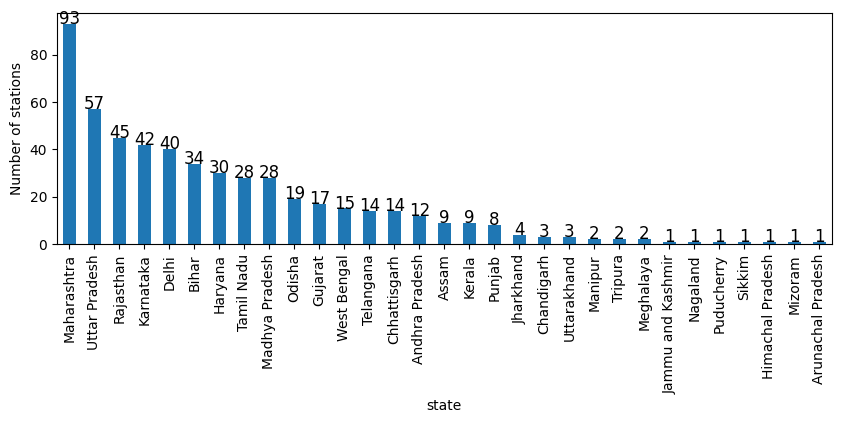

In [37]:
vc = check["state"].to_series().value_counts()
# plot the above as a bar plot along with annotations
fig, ax = plt.subplots(figsize=(10, 3))
vc.plot(kind="bar")
# annotate
for i, v in enumerate(vc):
    ax.text(i, v + 0.1, str(v), ha='center', size=12)
    
ax.set_ylabel("Number of stations")